# Cartera

Autores:
>Santiago Osorio Duque 

>Johan S. Méndez

## Objetivo:
Identificar si un registro necesita gestión de cobro con mora a mayor de 30 días

## Necesidad:
Poder tomar acciones tempranas y realizar las respectivas gestiones a los registros que necesitarán dado una predicción de mora de 30 días. Esto con el objetivo de reducir costos además de evitar la reducción de liquidez

## Análisis de información 
Se realizará limpieza de los datos que fueron suministrados. 
1. Comportamiento variables consignadas en la base de datos 
2. Encontrar relaciones entre ellas
3. Evolución a través del tiempo 

In [26]:
# Modulos escritos
from connect_database import connect
from low_variance import get_low_variance_columns

# Librerias 
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.feature_selection import VarianceThreshold


Se hace la lectura de la base de datos utilizando el módulo _connect_ que se encuentra escrito dentro del archivo __connect_database.py__. Con esto se establece la conexión a las bases guardadas en azure. A continuación se listan las bases a las cuales se quiere hacer la conexión 

In [4]:
server   = "carterasvr.database.windows.net"
database = "cartera"
username = "consulta"
password = "D4t4b1z2.123"

# Se establece la conexión 
cnxn = connect(server, database, username, password)

Petición SQL a la base de datos. Se almacena dentro de un marco de datos de Pandas

In [5]:
sql = ("""SELECT HIST_CARTERA.*, REGIONES.ID_REGION_NATURAL, REGIONES.NOMBRE AS REGION
FROM HIST_CARTERA LEFT JOIN
     (SELECT DIM_GEOGRAFIA.ID_GEOGRAFIA, DIM_GEOGRAFIA.ID_REGION_NATURAL, DRN.NOMBRE
FROM DIM_GEOGRAFIA
LEFT JOIN DIM_REGION_NATURAL DRN on DIM_GEOGRAFIA.ID_REGION_NATURAL = DRN.ID_REGION_NATURAL) REGIONES
ON HIST_CARTERA.ID_GEOGRAFIA = REGIONES.ID_GEOGRAFIA""")

data = pd.read_sql(sql, cnxn)


In [ ]:
data

### Campos Agregados 

Inclusión del primer campo __FECHA_CONSULTADA__, la fecha viene por defecto en la base de datos con el formato (__20181201.0__). Para el manejo de datos se cambia el formato para el tipo (__2018-12-01__) en el formato _datetime_ de pandas

In [6]:
data["FECHA_CONSULTADA"] = pd.to_datetime(data["ID_FECHA_CONSULTADA"].astype("int").astype("str"), format = "%Y-%m-%d")

Segundo campo agregado __DIAS_CONOCIMIENTO_FACTURA__ consigna los dias de diferencia entre el registro de cartera y la consulta, es decir, cuantos días el usuario conoce su retraso. Además se normaliza para que se tenga en el campo de datos sin unidades y como punto flotante

In [7]:
data["DIAS_CONOCIMIENTO_FACTURA"] = (data["FECHA_CONSULTADA"] - data["FECHA_REGISTRO_CARTERA"])/np.timedelta64(1, "D")

Tercer campo agregado __DIAS_MORA__. Se puede inferir con los campos de la base los días de mora del usuario, si el resultado es un valor negativo se hizo el pago antes del registro de la fecha de cobro. Se pueden presentar varios casos , pero es importante conocer la forma en que el banco hace el cobro para poder determinar si en realidad la mora se relaciona con atraso o con una mala política de cobro del banco.

Para los valores perdidos se van a utilizar una columna transitoria etiquetada con _fixed_ que va poner 1 día de mora a la base de datos. Luego de esto se utiliza esta variable transitoria para calcular la mora con la fecha de consulta del usuario

In [8]:
data["DIAS_MORA"] = (data["FECHA_PAGO"] - data["FECHA_COBRO"])/np.timedelta64(1, "D")

# Definicion de columna auxiliar
data["fixem"] = 0
# Rellenar valores perdidos con un dia de mora
data.at[data["DIAS_MORA"].isna(), "fixem"] = 1
# Calculo de la mora desde la fecha consultada 
data.at[data["fixem"]==1, "DIAS_MORA"] = (data[data["fixem"]==1]["FECHA_CONSULTADA"] - data[data["fixem"]==1]["FECHA_COBRO"])/np.timedelta64(1, "D")
# Descarte de la columna provisional
data = data.drop(columns="fixem")

Cuarto campo agregado __GESTION_COBRO__. Se identifican los usuarios que tengan mas de 30 días de mora para la identificación en la gestión de cobro

In [9]:
data["GESTION_COBRO"] = (data["DIAS_MORA"] > 30).astype(int)

Quinto campo agregado __SALDADA__. Se tiene para identificar quien esta con todas sus obligaciones saldadas

In [10]:
data["SALDADA"] = (~data["FECHA_PAGO"].isna()).astype("int")

Se construye entonces la base de datos con las columnas que se van a utilizar

In [12]:
keys = ["NUMERO_CONTRATO", "TIPO_IDENTIFICACION", "IDENTIFICACION", "SEXO", "INGRESO",
        "REGION", "REPUTACION_CLIENTE", "GARANTIA_COLATERAL_CLIENTE", "NIVEL_RIESGO_CLIENTE", "CAPACIDAD_CLIENTE", "CAPITAL_CLIENTE",
        "CIUDAD", "PROVINCIA_ESTADO_DEPARTAMENTO", "PLAZO_PACTADO", "CANTIDAD_CUOTAS_PAGADAS", "CANTIDAD_CUOTAS_PENDIENTES",
        "PORCENTAJE_INTERES_CORRIENTE_EA", "PORCENTAJE_INTERES_MORA_EA", "SALDO_CAPITAL_CONTRATO", "VALOR_INICIAL", "CANTIDAD_FACTURAS",
        "ID_CONTRATO", "ID_CLIENTE", "DIAS_MORA", "GESTION_COBRO", "DIAS_CONOCIMIENTO_FACTURA",
        "SALDADA"
       ]
DATA = data[keys]


Para saber si un usuario está en mora se crea a partir de la variable __GESTION_COBRO__ una variable binaria que clasifica al usuario en dos grupos, aquel que esté en mora(1) y aquel que no(0). 



## Descripción de las variables 

Se cambia el nombre de la variable respuesta 

In [13]:
DATA.rename(columns={"GESTION_COBRO": "RESPONSE"}, inplace=True)

# Debug this cell

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Variable objetivo

Se evidencia como están distribuidos los morosos

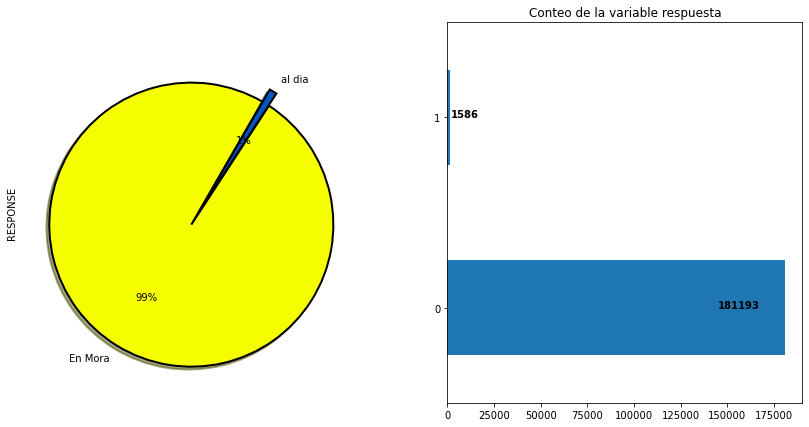

In [14]:
plt.figure(figsize=(14,7))

plt.subplot(121)
DATA["RESPONSE"].value_counts().plot.pie(autopct="%1.0f%%", 
                                         colors=sns.color_palette("prism",7), 
                                         startangle=60, 
                                         labels=["En Mora", "al dia"],
                                         wedgeprops={"linewidth":2, "edgecolor":"k"},
                                         explode=[.1, 0],
                                         shadow=True
                                        )
plt.subplot(122)
ax = DATA["RESPONSE"].value_counts().plot(kind="barh")
ax.text(DATA["RESPONSE"].value_counts()[0] * 0.8, 0, DATA["RESPONSE"].value_counts()[0], weight="bold")
ax.text(DATA["RESPONSE"].value_counts()[1]*1.1 , 1, DATA["RESPONSE"].value_counts()[1], weight="bold")

plt.title("Conteo de la variable respuesta")
plt.show()




Se hace la descripción por tipos de variables en la base de datos 

In [41]:
columns_object  = DATA.select_dtypes(include=["object"]).columns
columns_numeric = DATA.select_dtypes(include=["int", "float"]).columns
DATA[columns_numeric]

,INGRESO,REPUTACION_CLIENTE,GARANTIA_COLATERAL_CLIENTE,NIVEL_RIESGO_CLIENTE,CAPACIDAD_CLIENTE,CAPITAL_CLIENTE,PLAZO_PACTADO,CANTIDAD_CUOTAS_PAGADAS,CANTIDAD_CUOTAS_PENDIENTES,PORCENTAJE_INTERES_CORRIENTE_EA,PORCENTAJE_INTERES_MORA_EA,SALDO_CAPITAL_CONTRATO,VALOR_INICIAL,CANTIDAD_FACTURAS,ID_CONTRATO,ID_CLIENTE,DIAS_MORA,RESPONSE,DIAS_CONOCIMIENTO_FACTURA,SALDADA
0,2454284.0,4.0,4.0,4.0,1.0,4.0,96.0,61.0,35.0,8.95,18.95,6487016.0,17793000.0,62,8689.0,3929.0,-12.0,0,8.0,1
1,5492814.0,5.0,2.0,5.0,3.0,5.0,60.0,3.0,57.0,7.45,22.20,14700300.0,15474000.0,4,11372.0,5614.0,-11.0,0,9.0,1
2,5946697.0,3.0,3.0,1.0,5.0,3.0,84.0,27.0,57.0,15.10,18.95,34162009.0,50344000.0,28,7070.0,6182.0,-14.0,0,9.0,1
3,5489184.0,5.0,1.0,5.0,5.0,4.0,96.0,6.0,90.0,11.45,18.95,58750314.0,62667000.0,7,10940.0,2145.0,-6.0,0,9.0,1
4,5005455.0,5.0,5.0,5.0,5.0,2.0,48.0,9.0,39.0,15.10,20.99,5231686.0,6439000.0,10,12811.0,3294.0,-11.0,0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,1806612.0,4.0,3.0,5.0,4.0,1.0,96.0,12.0,84.0,10.30,17.45,32809004.0,37496000.0,13,6678.0,10605.0,-13.0,0,9.0,1
182775,609600.0,4.0,1.0,2.0,3.0,4.0,96.0,2.0,94.0,15.10,18.95,38539020.0,39359000.0,3,5952.0,8766.0,-15.0,0,9.0,1
182776,2177628.0,5.0,1.0,2.0,1.0,1.0,84.0,5.0,79.0,12.20,20.99,38301835.0,40726000.0,6,12480.0,9006.0,-8.0,0,9.0,1
182777,1539082.0,4.0,3.0,1.0,5.0,4.0,96.0,3.0,93.0,15.10,18.95,54101780.0,55847000.0,4,8604.0,797.0,-3.0,0,9.0,1


### Variables Numéricas

### Verificación de baja varianza


> Hay muchos modelos en los que los predictores con un único valor (también conocidos como "predictores de varianza cero") harán que el modelo falle. Dado que se ajustarán los modelos utilizando métodos de remuestreo, una muestra aleatoria del conjunto de entrenamiento puede dar como resultado que algunos predictores con más de un valor único se conviertan en un predictor de varianza cero. Estos son los llamados "predictores de varianza cercana a cero" pueden causar problemas numéricos durante el remuestreo para algunos modelos, como la regresión lineal.

Por esta razón es necesario verificar todos las variables predictivas numéricas para evitar errores en las regresiones

In [56]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

variance_threshold_selector(DATA[columns_numeric])

,INGRESO,REPUTACION_CLIENTE,GARANTIA_COLATERAL_CLIENTE,NIVEL_RIESGO_CLIENTE,CAPACIDAD_CLIENTE,CAPITAL_CLIENTE,PLAZO_PACTADO,CANTIDAD_CUOTAS_PAGADAS,CANTIDAD_CUOTAS_PENDIENTES,PORCENTAJE_INTERES_CORRIENTE_EA,PORCENTAJE_INTERES_MORA_EA,SALDO_CAPITAL_CONTRATO,VALOR_INICIAL,CANTIDAD_FACTURAS,ID_CONTRATO,ID_CLIENTE,DIAS_MORA,DIAS_CONOCIMIENTO_FACTURA
0,2454284.0,4.0,4.0,4.0,1.0,4.0,96.0,61.0,35.0,8.95,18.95,6487016.0,17793000.0,62,8689.0,3929.0,-12.0,8.0
1,5492814.0,5.0,2.0,5.0,3.0,5.0,60.0,3.0,57.0,7.45,22.20,14700300.0,15474000.0,4,11372.0,5614.0,-11.0,9.0
2,5946697.0,3.0,3.0,1.0,5.0,3.0,84.0,27.0,57.0,15.10,18.95,34162009.0,50344000.0,28,7070.0,6182.0,-14.0,9.0
3,5489184.0,5.0,1.0,5.0,5.0,4.0,96.0,6.0,90.0,11.45,18.95,58750314.0,62667000.0,7,10940.0,2145.0,-6.0,9.0
4,5005455.0,5.0,5.0,5.0,5.0,2.0,48.0,9.0,39.0,15.10,20.99,5231686.0,6439000.0,10,12811.0,3294.0,-11.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,1806612.0,4.0,3.0,5.0,4.0,1.0,96.0,12.0,84.0,10.30,17.45,32809004.0,37496000.0,13,6678.0,10605.0,-13.0,9.0
182775,609600.0,4.0,1.0,2.0,3.0,4.0,96.0,2.0,94.0,15.10,18.95,38539020.0,39359000.0,3,5952.0,8766.0,-15.0,9.0
182776,2177628.0,5.0,1.0,2.0,1.0,1.0,84.0,5.0,79.0,12.20,20.99,38301835.0,40726000.0,6,12480.0,9006.0,-8.0,9.0
182777,1539082.0,4.0,3.0,1.0,5.0,4.0,96.0,3.0,93.0,15.10,18.95,54101780.0,55847000.0,4,8604.0,797.0,-3.0,9.0


Dos columnas fueron excluidas de la base de datos. __RESPONSE__ y __SALDADA__. La variable __RESPONSE__ corresponde a la variable objetivo y la variable __SALDADA__ se relaciona con ella. Por tanto no se remueve ninguna por baja varianza

### Eliminación de valores atípicos

En primer lugar se hace una revisión rápida a cada variable para saber si existe valores atípicos evidentes. Se hace la diferencia entre variables categóricas que están indexadas por números, estas se representan en diagramas de barras para ver la distribución de categorias. Para las variables numéricas se hace un diagrama de caja, este permite identificar valores atípicos rápidamente para elegir una estrategia de eliminación de valores atípicos

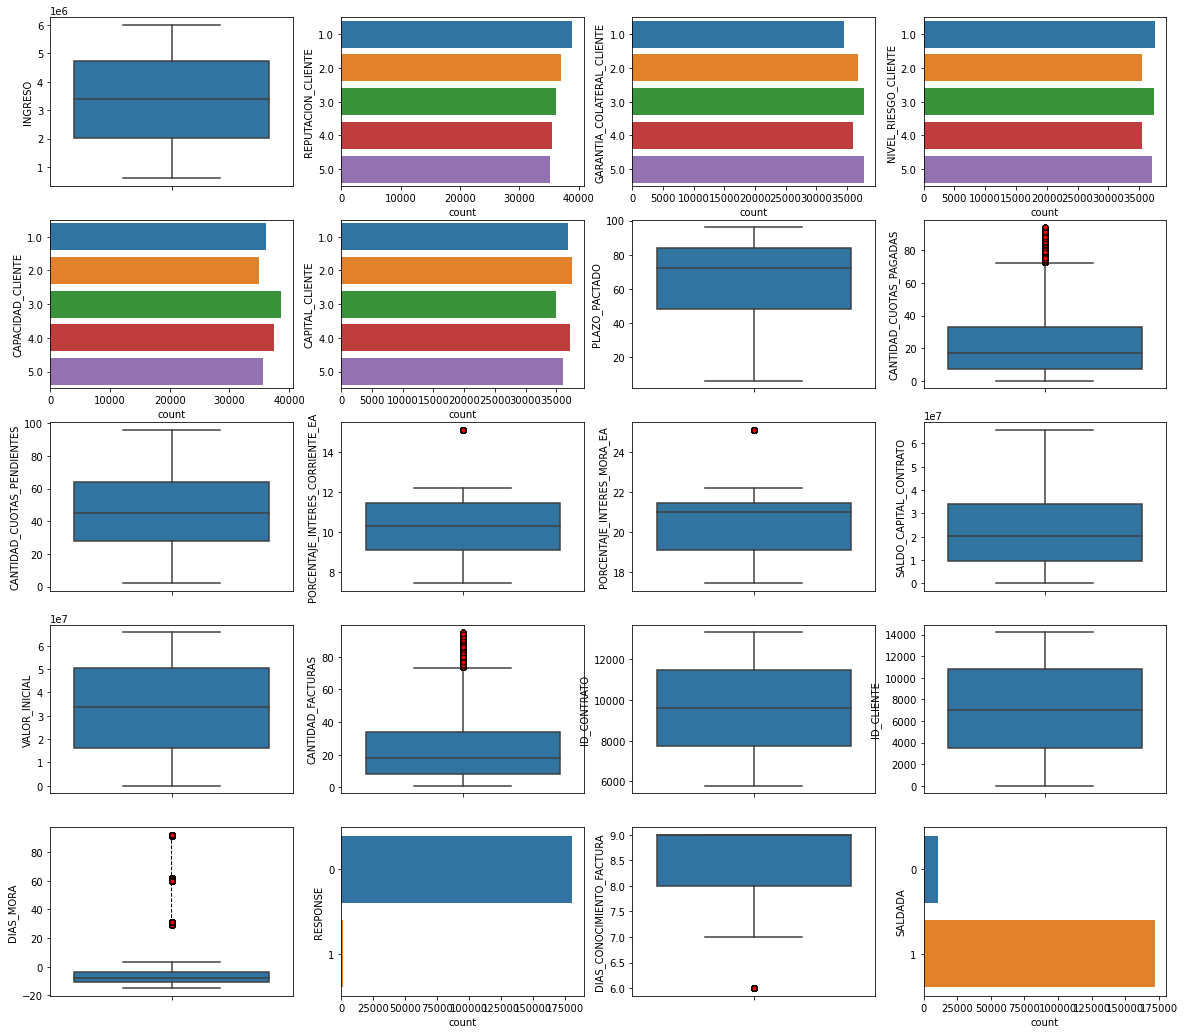

In [111]:
row = 5
columns = 4
fig, ax = plt.subplots(row, columns, figsize=(20, 18))

flp = dict(marker="o",
           markerfacecolor="red",
           markersize=5,
           linestyle="--",
           markeredgecolor="black")
count = 0

for i in range(row):
    for j in range(columns):
        plot_data = DATA[columns_numeric][DATA[columns_numeric].columns[count]]
        if DATA[columns_numeric].columns[count] == "REPUTACION_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "GARANTIA_COLATERAL_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "NIVEL_RIESGO_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "CAPACIDAD_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "CAPITAL_CLIENTE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "RESPONSE":
            sns.countplot(y=plot_data,ax=ax[i,j])
        elif DATA[columns_numeric].columns[count] == "SALDADA":
            sns.countplot(y=plot_data,ax=ax[i,j])
        else:
            sns.boxplot(y=plot_data, ax=ax[i,j], flierprops=flp)
        count += 1


### Variables categóricas

In [19]:
columns_object

Index(['NUMERO_CONTRATO', 'TIPO_IDENTIFICACION', 'IDENTIFICACION', 'SEXO',
       'REGION', 'CIUDAD', 'PROVINCIA_ESTADO_DEPARTAMENTO'],
      dtype='object')

### Sexo

Se hace evidente la distribución del Genero en la base de datos

Text(0.5, 1.0, 'Distribución de la variable RESPONSE por SEXO')

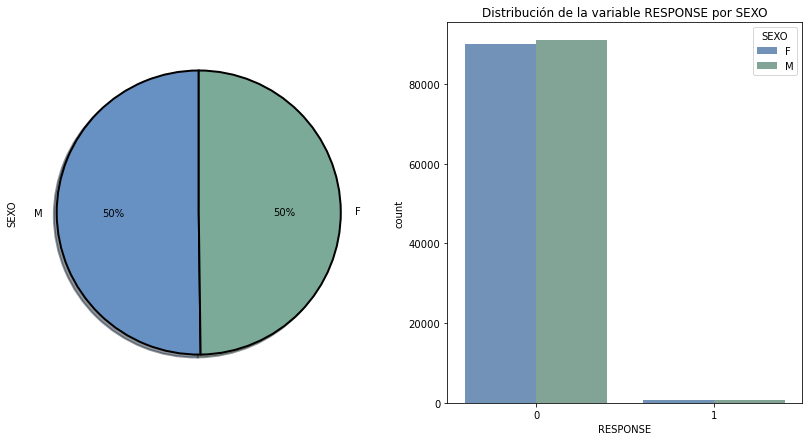

In [176]:
fig = plt.figure(figsize=(14,7))

plt.subplot(121)
data["SEXO"].value_counts().plot.pie(autopct="%1.0f%%",
                                     colors=["#6891C3", "#7CAA98"],
                                     startangle=90,
                                     wedgeprops={"linewidth":2, "edgecolor":"k"},
                                     shadow=True,
                                    )

plt.subplot(122)
ax = sns.countplot("RESPONSE", hue="SEXO", data=DATA, palette=["#6891C3", "#7CAA98"])
ax.set_title("Distribución de la variable RESPONSE por SEXO")


### Distribución por región 

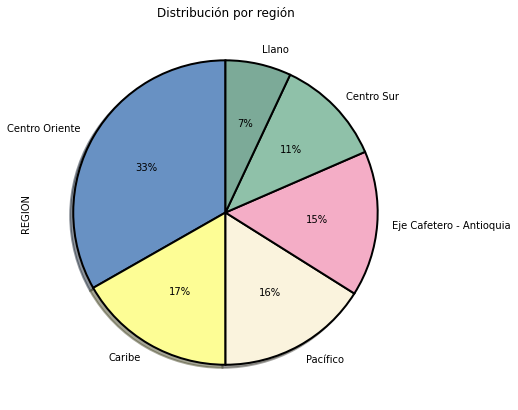

In [179]:
plt.figure(figsize=(14,7))
data["REGION"].value_counts().plot.pie(autopct="%1.0f%%",
                                       colors=["#6891C3", "#FDFD95", "#FAF3DD", "#F4ADC6", "#8FC1A9","#7CAA98"],
                                       startangle=90,
                                       wedgeprops={"linewidth":2, "edgecolor":"k"},
                                       shadow=True,
                                      )
plt.title("Distribución por región")
plt.show()

### Variables del producto financiero


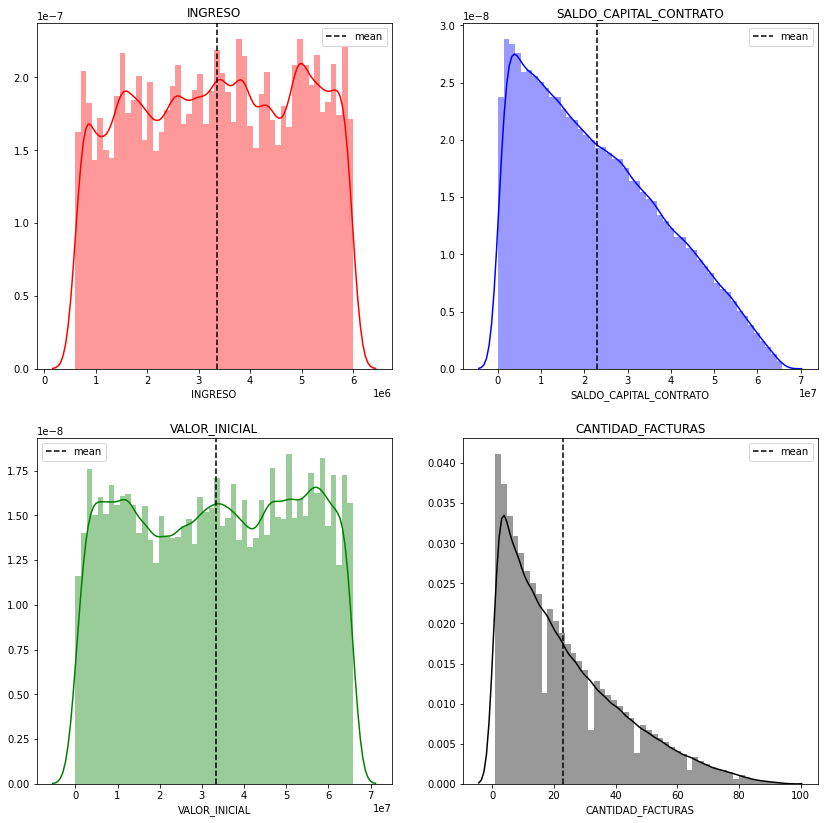

In [191]:
product_cols = ["INGRESO", "SALDO_CAPITAL_CONTRATO", "VALOR_INICIAL", "CANTIDAD_FACTURAS"]
colors = ["r", "b", "g", "k"]

plt.figure(figsize=(14,14))
for i,j,k in itertools.zip_longest(product_cols, range(len(product_cols)), colors):
    plt.subplot(2,2,j+1)
    sns.distplot(DATA[DATA[i].notnull()][i], color=k)
    plt.axvline(DATA[i].mean(), label="mean", linestyle="dashed", color="k")
    plt.legend(loc="best")
    plt.title(i)
    plt.subplots_adjust(hspace=0.2)